<a href="https://colab.research.google.com/github/ThanosApostolou/aics-pattern-recognition/blob/main/IMDB.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# thanos
# Load the TensorBoard notebook extension
%load_ext tensorboard
# Import tensorflow
import tensorflow as tf
import datetime, os
from google.colab import drive
drive.mount('/content/drive/')

Mounted at /content/drive/


In [ ]:
import numpy as np 
import pandas as pd
import os
import matplotlib.pyplot as plt
##MAIN PROGRAM VARIABLES##
##(0): dataset: np array of strings
##(1): dataframe: original dataset in its primal form
##(2): ratings_num_df: new dataframe storing the number of rated items per unique user
##(3): ratings_span_df: new dataframe storing the timespan in days for each user
##(4): minimum_ratings - maximum_ratings => ratings_df=> (i) final_df

In [5]:
dataset = np.load('/content/drive/My Drive/Colab Notebooks/Dataset.npy')

In [7]:
#Define the figures path
FIGURES_PATH = "figures"
os.makedirs(FIGURES_PATH, exist_ok=True)
# #Define the data folder path
DATAFOLDER_PATH = "datafile"
os.makedirs(DATAFOLDER_PATH, exist_ok=True)
#Load the dataset in an np array
#datafile = "datafile/Dataset.npy"
#dataset=np.load(dataset)

In [8]:
#Define the splitter lambda function in order to tokenize the initial string data.
splitter = lambda s: s.split(",")
#Apply the splitter lambda function on the string np array
dataset = np.array([splitter(x) for x in dataset])
#Set the pickle file for storing the initial dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "dataframe.pkl")
#Check the existence of the specified file.
if os.path.exists(pickle_file):
    #Load the pickle file
    dataframe = pd.read_pickle(pickle_file)
else:
    #Create the dataframe object.
    dataframe = pd.DataFrame(dataset, columns=['User','Movie','Rating','Date'])
    #Convert the string elements of the "Users" series into integers
    dataframe["User"] = dataframe["User"].apply(lambda s:np.int64(s.replace("ur","")))
    #Convert the string elements of the "Movies" series into integers
    dataframe["Movie"] = dataframe["Movie"].apply(lambda s:np.int64(s.replace("tt","")))
    #Convert the string elements of the "Ratings" series into integers
    dataframe["Rating"] = dataframe["Rating"].apply(lambda s:np.int64(s))
    #Convert the string element of "Dates" series into datetime Object
    dataframe["Date"] = pd.to_datetime(dataframe["Date"])
    dataframe.to_pickle(pickle_file)

In [10]:
#Get the unique users in the dataset.
users = dataframe["User"].unique()
#Get the number of unique users
users_num = len(users)
#Get the unique movie items in the dataset.
movies = dataframe["Movie"].unique()
#Get the number of unique movies
movies_num = len(movies)
#Get the total number of existing ratings.
ratings_num = dataframe.shape[0]
#Report the number of unique Users and Movies in the dataset
print("INITIAL DATASET: {0} number of unique users and {1} of unique movies".format(users_num, movies_num))
#Report the total number of existing ratings in the dataset
print("INITIAL DATASET: {} total number of existing ratings".format(ratings_num))

INITIAL DATASET: 1499238 number of unique users and 351109 of unique movies
INITIAL DATASET: 4669820 total number of existing ratings


In [11]:
#Define the pickle file that will store the time span per user dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_num_df.pkl")
#Check the existence of the previously defined pickle file
if os.path.exists(pickle_file):
    #Load the pickle file
    ratings_num_df = pd.read_pickle(pickle_file)
else:
    ratings_num_df = dataframe.groupby("User")["Rating"].count().sort_values(ascending=False).reset_index(name="ratings_num")
    #Save the previously created dataframe to pickle
    ratings_num_df.to_pickle(pickle_file)

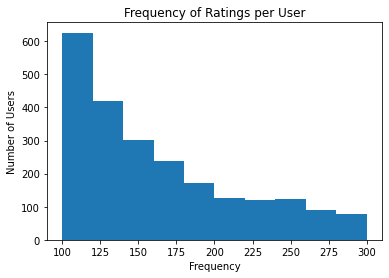

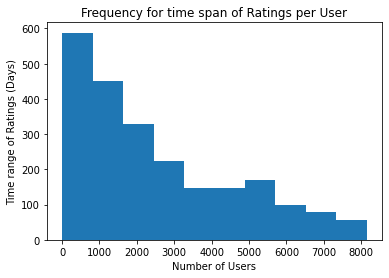

In [12]:
#Set the pickle file that will store the time span per user dataframe
pickle_file = os.path.join(DATAFOLDER_PATH, "ratings_span_df.pkl")
if os.path.exists(pickle_file):
    ratings_span_df = pd.read_pickle(pickle_file)
else:
    ratings_span_df = dataframe.groupby("User")["Date"].apply(lambda date: max(date)-min(date)).sort_values(ascending=False).reset_index(name="ratings_span")
    ratings_span_df.to_pickle(pickle_file)
#Create a new ratings dataframe by joining the previously defined dataframe
ratings_df = ratings_num_df.join(ratings_span_df.set_index("User"),on="User")
ratings_df["ratings_span"]=ratings_df["ratings_span"].dt.days
#Set the threshold values for the minimum and maximum number of Ratings per user
minimum_ratings = 100
maximum_ratings = 300
#Discard all users that do not pertain to the previous range of ratings
reduced_ratings_df = ratings_df.loc[(ratings_df["ratings_num"] >= minimum_ratings) & (ratings_df["ratings_num"] <= maximum_ratings)]

#Generate the frequency histogram for the number of ratings per user
reduced_ratings_df["ratings_num"].plot(kind='hist', title='Frequency of Ratings per User', xticks=range(minimum_ratings, maximum_ratings+1, 25))
plt.xlabel('Frequency')
plt.ylabel('Number of Users')

plt.show()
#Generate the frequency histogram for the time span of ratings per user
reduced_ratings_df["ratings_span"].plot(kind='hist', title='Frequency for time span of Ratings per User')
plt.xlabel('Number of Users')
plt.ylabel('Time range of Ratings (Days)')

plt.show()



                                                                                    

In [13]:
#Get the final dataframe by excluding all users whose ratings fall outside the prespecified range
final_df = dataframe.loc[dataframe["User"].isin(reduced_ratings_df["User"])].reset_index()
#Drop the links (indices) to the original table
final_df = final_df.drop("index", axis=1)
#Get the unique users and items in the final dataframe along with the final number of ratings
final_users = final_df["User"].unique()
final_movies = final_df["Movie"].unique()
final_users_num = len(final_users)
final_movies_num = len(final_movies)
final_ratings_num = len(final_df)

#Report the final number of unique users and movies in the dataset
print("REDUCED DATASET: {0} number of unique users and {1} number of unique movies".format(final_users_num, final_movies_num))
#Report the final number of existing ratings in the dataset
print("REDUCED DATASET: {} number of existing ratings in the dataset".format(final_ratings_num))

REDUCED DATASET: 2292 number of unique users and 91949 number of unique movies
REDUCED DATASET: 370860 number of existing ratings in the dataset


In [14]:
#We need to reset the users and items IDs in order to be able to construct a network of users and Movies. 
#Users and Movies IDs should be consecutive in the [1..final_users_num] and [1...final_movies_num]
#Initially, we need to acquire the sorted versions of the user and movies
sorted_final_users = np.sort(final_users)
sorted_final_movies = np.sort(final_movies)
#Generate the dictionary of final users as a mapping of the following 
#sorted_final_users --> [0...final_users_num-1]
final_users_dict = dict(zip(sorted_final_users,list(range(0,final_users_num))))
#Generate the dictionary of final items as a mapping of the following
final_movies_dict = dict(zip(sorted_final_movies,list(range(0,final_movies_num))))
#Apply the previously defined dictionary-based maps on the users and movies columns of the final dataframe
final_df["User"] = final_df["User"].map(final_users_dict)
final_df["Movie"] = final_df["Movie"].map(final_movies_dict)
#Get a grouped version of the original dataframe based on the unique final users
users_group_df = final_df.groupby("User")
#Initialize the adjacency matrix which stores the connection status for pair of users in the recommendation network
W = np.zeros((final_users_num, final_users_num))
#Iinitialize the matrix storing the number of commonly rated items for a pair of users
CommonRatings = np.zeros((final_users_num, final_users_num))
#Initialize the matrix of common ratings
#Matrix W will be of size [final_users_num x final_users_num],
#Let U = {u1, u2,...,un} be the final set of users and I = {i1,i2,...,im}
#final set of movies. By considering the function Fi: U -> P(I) where
#P(I) is the powerset of I, Fi(u) returns the subset of items that has been rated by user u. 
#In this context, the edge weight between any given pair of users (u,v) will be computed as:
#
#          |Intersection(Fi(u)),Fi(v))|
#W(u,v) =  -----------------------------
#               |Union(Fi(u),Fi(v))|
#
#
#In order to speed up the construction of the adjacency matrix for the ratings network, 
#construct a dictionary object that will store a set of rated items for each unique user.
user_items_dict = {}
# for user in final_users:
    #print(user)
    # user_index = final_users_dict[user]
    # user_movies = set(users_group_df.get_group(user_index)["Movie"])
    # user_items_dict[user_index] = user_movies
                                                 
# Initialize the dictionary for storing the set of rated items for each user
user_items_dict = {}
# print(final_users_dict)
# print(sorted_final_users)
# print(final_users_dict)
# For each unique user, find the set of movies that they rated
for user in final_users:
    if user in final_users_dict:
        user_index = final_users_dict[user]
        user_movies = set(users_group_df.get_group(user_index)["Movie"])
        user_items_dict[user_index] = user_movies 

In [15]:
user_ids = list(user_items_dict.keys())
user_ids.sort()
#Generate the sorted version of the dictionary
user_items_dict = {user_index:user_items_dict[user_index] for user_index in user_ids}
#Set the pickle file that will store the graph adjacency matrix W.
pickle_file_weights = os.path.join(DATAFOLDER_PATH, "w")
pickle_file_common_ratings = os.path.join(DATAFOLDER_PATH, "common_ratings")
#Check the existence of the previously defined pickle file
if os.path.exists(pickle_file_weights) & os.path.exists(pickle_file_common_ratings):
    #Load the pickle file
    W = np.load(pickle_file_weights)
    CommonRatings = np.load(pickle_file_common_ratings)
else:
    for source_user in user_items_dict.keys():
        for target_user in user_items_dict.keys():
            intersection_items = user_items_dict[source_user].intersection(user_items_dict[target_user])
            union_items = user_items_dict[source_user].union(user_items_dict[target_user])
            W[source_user, target_user] = len(intersection_items)/len(union_items)
            CommonRatings[source_user, target_user] = len(intersection_items)
    np.save(pickle_file_weights,W)
    np.save(pickle_file_common_ratings,CommonRatings)

In [16]:
W

array([[1.        , 0.00257732, 0.        , ..., 0.00998004, 0.02122016,
        0.00481928],
       [0.00257732, 1.        , 0.        , ..., 0.        , 0.00492611,
        0.        ],
       [0.        , 0.        , 1.        , ..., 0.        , 0.        ,
        0.00414938],
       ...,
       [0.00998004, 0.        , 0.        , ..., 1.        , 0.00626959,
        0.        ],
       [0.02122016, 0.00492611, 0.        , ..., 0.00626959, 1.        ,
        0.        ],
       [0.00481928, 0.        , 0.00414938, ..., 0.        , 0.        ,
        1.        ]])

In [17]:
CommonRatings

array([[285.,   1.,   0., ...,   5.,   8.,   2.],
       [  1., 104.,   0., ...,   0.,   1.,   0.],
       [  0.,   0., 110., ...,   0.,   0.,   1.],
       ...,
       [  5.,   0.,   0., ..., 221.,   2.,   0.],
       [  8.,   1.,   0., ...,   2., 100.,   0.],
       [  2.,   0.,   1., ...,   0.,   0., 132.]])

In [18]:
final_df

,User,Movie,Rating,Date
0,674,14589,10,2005-01-16
1,558,25059,8,2005-01-16
2,366,33517,6,2005-01-16
3,616,37484,10,2005-01-16
4,450,8762,2,2005-01-16
...,...,...,...,...
370855,572,37373,6,2005-01-15
370856,29,35124,7,2005-01-16
370857,495,22042,6,2005-01-16
370858,29,34937,9,2005-01-16


In [19]:
# Create a pivot table of user-movie ratings
ratings_matrix = final_df.pivot_table(index='User', columns='Movie', values='Rating')
ratings_matrix = ratings_matrix.fillna(0)

In [ ]:
ratings_matrix

Movie,0,1,2,3,4,5,6,7,8,9,...,91939,91940,91941,91942,91943,91944,91945,91946,91947,91948
User,,,,,,,,,,,,,,,,,,,,,
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2287,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2288,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2289,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [ ]:
!pip install pyclustering
from pyclustering.cluster.kmeans import kmeans, kmeans_visualizer
from pyclustering.cluster.center_initializer import kmeans_plusplus_initializer
from pyclustering.samples.definitions import FCPS_SAMPLES
from pyclustering.utils import read_sample
from pyclustering.cluster.kmeans import kmeans
from pyclustering.utils.metric import type_metric, distance_metric

In [ ]:
# Threshold
threshold = 1

# Transform to binary
binary_matrix = np.where(ratings_matrix >= threshold, 1, 0)

In [ ]:
binary_matrix

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
# Convert the matrix to a numpy array
matrix_array = ratings_matrix.to_numpy()

# Create a dictionary that maps each row of the matrix to its index
matrix_dict = {tuple(row): i for i, row in enumerate(matrix_array)}

In [ ]:
# Calculate the weighted Euclidean distance matrix
D = np.zeros((ratings_matrix.shape[0], ratings_matrix.shape[0]))

for i in range(ratings_matrix.shape[0]):
    print(i)
    for j in range(i, ratings_matrix.shape[0]):
        d = np.sqrt(np.sum(binary_matrix[i,:]*binary_matrix[j,:] * (ratings_matrix.iloc[i,:] - ratings_matrix.iloc[j,:])**2))
        D[i,j] = d
        D[j,i] = d


0


AttributeError: 'numpy.ndarray' object has no attribute 'iloc'

In [ ]:
# Compute the binary matrix
binary_matrix = ratings_matrix.notna().astype(int)

# Compute the pairwise distances between the binary rows
row_norms = np.sum(binary_matrix ** 2, axis=1)
dot_product = binary_matrix @ binary_matrix.T
distance_matrix_binary = np.sqrt(row_norms[:, np.newaxis] + row_norms - 2*dot_product)

# Compute the pairwise distances between the ratings
rating_diff = ratings_matrix.values[:, np.newaxis, :] - ratings_matrix.values
distance_matrix_rating = np.sqrt(np.sum((binary_matrix[:, np.newaxis, :] * rating_diff) ** 2, axis=-1))

# Compute the weighted Euclidean distance
weighted_distance_matrix = distance_matrix_rating * distance_matrix_binary


In [ ]:
D

In [ ]:
# Calculate the weighted Euclidean distance matrix
# D = np.zeros((ratings_matrix.shape[0], ratings_matrix.shape[0]))

# for i in range(ratings_matrix.shape[0]):
#     for j in range(i, ratings_matrix.shape[0]):
D = np.zeros((100, 100))
for i in range(100):
    for j in range(i, 100):
        d = np.sqrt(np.sum(binary_matrix[i,:]*binary_matrix[j,:] * (ratings_matrix.loc[i,:] - ratings_matrix.loc[j,:])**2))
        D[i,j] = d
        D[j,i] = d

In [ ]:
D

In [ ]:
from sklearn.cluster import KMeans
# Cluster the users using K-means
kmeans = KMeans(n_clusters=5).fit(D)

# Get the cluster labels
labels = kmeans.labels_

# Print the labels for the first 10 users
print(labels)